### Setting up and retrieving data

#### Imports
Performing the necessary imports for the file to run. Main imports that are used are as follows:
- pandas/numpy: Working with data
- transformers: BERT Tokenizer
- tensorflow: Model Architecture
- matplotlib: Visualisation of performance

In [ ]:
import os

import pandas as pd

from transformers import AutoTokenizer, TFAutoModel

import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EPOCHS = 10
BATCH_SIZE = 16
LSTM_UNITS = 64

# Set a seed to decrease randomness
SEED = 42
tf.random.set_seed(SEED)

# Set the model file to refer to
MODEL_NAME = 'microsoft/deberta-v3-base'
TOKENIZER_NAME = 'bilstm.deberta-v3-base.tokenizer.json'
SAVED_NAME = 'bilstm.deberta.keras'
WEIGHTS_FILE = 'bilstm.deberta-v3-base.weights.h5'

#### Load CSV files
Loading CSV files from the train and dev csv for preprocessing

In [ ]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('dev.csv')

#### Set up BERT-based Tokenizer
Instantiates the tokenizer based on the model name above and define functions for encoding sentences

In [ ]:
# Instantiate Tokenizer on MODEL_NAME (BERT)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Encodes sentence
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

# Encode data for the bert model with a max length of MAX_SEQUENCE_LENGTH
def bert_encode(hypotheses, premises, tokenizer, max_length=MAX_SEQUENCE_LENGTH):

    x = tokenizer(hypotheses, premises, padding='max_length', truncation=True, max_length=max_length)

    inputs = {
          'input_word_ids':tf.ragged.constant(x['input_ids']).to_tensor(),
          'input_mask': tf.ragged.constant(x['attention_mask']).to_tensor(),
          'input_type_ids': tf.ragged.constant(x['token_type_ids']).to_tensor()}

    return inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
train_input = bert_encode(train.premise.values.tolist(), train.hypothesis.values.tolist(), tokenizer)

In [ ]:
valid_input = bert_encode(valid.premise.values.tolist(), valid.hypothesis.values.tolist(), tokenizer)

### Model Architecture


In [ ]:
os.environ["WANDB_API_KEY"] = "0"

# Define function to build the model
def build_model():
    # BERT encoder layer that is non-trainable
    bert_encoder = TFAutoModel.from_pretrained(MODEL_NAME, trainable=False)

    # Tokenized input sequence (word indices), Mask to indicate real tokens/padding, Type Ids
    input_word_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_type_ids")

    # Encodes all 3 inputs
    output = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]

    # BiLSTM layer and normalisation to prevent overfitting.
    output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS))(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Dropout(0.1)(output)
    output = tf.keras.layers.Dense(64, activation='relu')(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Dropout(0.1)(output)

    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    # Returns the model
    return tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

In [ ]:
# Builds the model
model = build_model()
model.summary()

tf_model.h5:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                              

In [ ]:
# Compiles the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Setting up Early Stopping with callback to checkpoint for the training of the model which monitors val loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)
checkpoint_filepath = WEIGHTS_FILE

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True)

### Training the model
Firstly, creating tensorflow datasets from both the training and validation set. Then, proceed to fit the model.

In [ ]:
# Create a TensorFlow dataset from the training data and shuffles them with seed=42
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train.label.values.reshape(-1,1)))
train_dataset = train_dataset.shuffle(SEED, reshuffle_each_iteration=True).batch(BATCH_SIZE)

# Create a TensorFlow dataset from the valid data and batch them up
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_input, valid.label.values.reshape(-1,1)))
valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [ ]:
# Fitting the model
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = valid_dataset,
    callbacks=[early_stopping, model_checkpoint_callback]
)

# Saving the model
model.save(SAVED_NAME)

Epoch 1/10


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


1527/1527 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7184

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


1527/1527 [==============================] - 473s 285ms/step - loss: 0.5521 - accuracy: 0.7184 - val_loss: 0.3709 - val_accuracy: 0.8458
Epoch 2/10
1527/1527 [==============================] - 425s 278ms/step - loss: 0.3998 - accuracy: 0.8269 - val_loss: 0.3370 - val_accuracy: 0.8612
Epoch 3/10
1527/1527 [==============================] - 437s 286ms/step - loss: 0.3732 - accuracy: 0.8432 - val_loss: 0.3480 - val_accuracy: 0.8553
Epoch 4/10
1527/1527 [==============================] - 426s 279ms/step - loss: 0.3526 - accuracy: 0.8534 - val_loss: 0.3139 - val_accuracy: 0.8734
Epoch 5/10
1527/1527 [==============================] - 427s 280ms/step - loss: 0.3426 - accuracy: 0.8594 - val_loss: 0.3148 - val_accuracy: 0.8716
Epoch 6/10
1527/1527 [==============================] - 427s 280ms/step - loss: 0.3305 - accuracy: 0.8647 - val_loss: 0.3190 - val_accuracy: 0.8743
Epoch 7/10
1527/1527 [==============================] - 422s 277ms/step - loss: 0.3254 - accuracy: 0.8662 - val_loss: 0.303

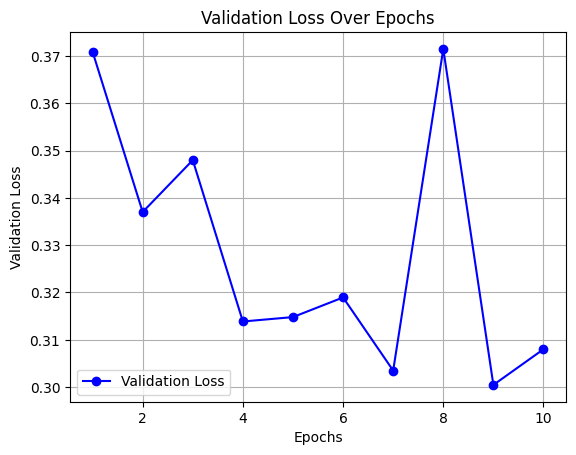

In [ ]:
# Visualisation of the performance of the val loss across epoch
val_loss = history.history['val_loss']

# Plot the validation loss over epochs
plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', linestyle='-', color='b', label="Validation Loss")

# Labeling the graph
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

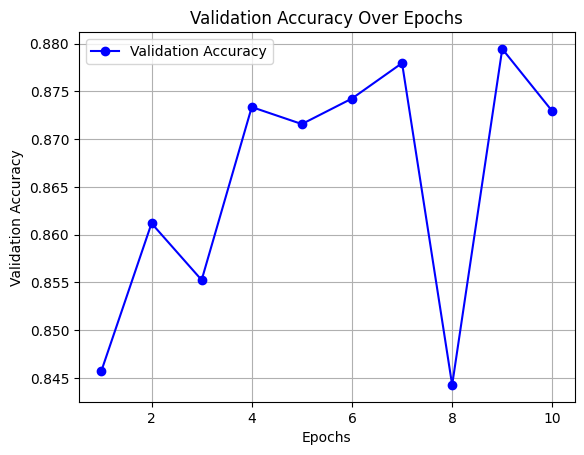

In [ ]:
# Visualisation of the performance of the val acc across epoch
val_acc = history.history['val_accuracy']

# Plot the validation loss over epochs
plt.plot(range(1, len(val_loss) + 1), val_acc, marker='o', linestyle='-', color='b', label="Validation Accuracy")

# Labeling the graph
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()